In [65]:
import pandas as pd
import numpy as np
from time import perf_counter, perf_counter_ns
from time import sleep
from datetime import datetime 
from datetime import timedelta
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
# import datetime
import json
import os
from sys import getsizeof
# import datetime
import random
# from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv
# from py_vollib.black_scholes.greeks import analytical as greeks
# import time
# import ks_api_client
from kiteconnect import KiteConnect
# from kiteconnect import KiteTicker

In [5]:
current_datetime = datetime(2021,5,17,15,0)
start_datetime = datetime(2021,5,17,15,15)
historical_data_folder_name = 'historical data'
fno_folder_name='FNO'
equity_folder_name="Equity"
underlying_name= 'NIFTY'

ltp_to_position_distance = .3


parent = os.path.dirname(os.getcwd())

historical_data_folder_path = os.path.join(\
        parent,historical_data_folder_name)

fno_data_folder_path = os.path.join(\
        historical_data_folder_path,fno_folder_name)

equity_data_folder_path = os.path.join(\
    historical_data_folder_path,equity_folder_name)

first_day_string = current_datetime.strftime("%Y-%m-%d")
first_fno_file_path = fno_file_paths = [\
        os.path.join(fno_data_folder_path,f) \
        for f in os.listdir(fno_data_folder_path) \
            if os.path.isfile(os.path.join(fno_data_folder_path,f)) \
                & (f.split(".")[0].split("_")[0] == first_day_string)\
                    ]

first_fno_df = pd.read_csv(first_fno_file_path[0])

end_datetime = pd.to_datetime(first_fno_df['expiry_date']).min() + timedelta (hours=15, minutes =30)

delta = timedelta(days=1)
start_date = current_datetime.date()
datestring_list = []
while start_date <= end_datetime.date():
    # print(start_date)
    datestring_list.append(start_date.strftime("%Y-%m-%d"))
    start_date += delta



fno_file_paths = [\
        os.path.join(fno_data_folder_path,f) \
        for f in os.listdir(fno_data_folder_path) \
            if os.path.isfile(os.path.join(fno_data_folder_path,f)) \
                & (f.split(".")[0].split("_")[0] in datestring_list)\
                    ]
fno_file_paths.sort()

equity_file_paths = [\
    os.path.join(equity_data_folder_path,f) \
    for f in os.listdir(equity_data_folder_path) \
        if os.path.isfile(os.path.join(equity_data_folder_path,f)) \
            & (f.split(".")[0].split("_")[0] in datestring_list)\
                ]
equity_file_paths.sort()


def size_and_rows(count, df):
    print(f"\t{count}\tSize: {round(getsizeof(df)/1_000_000,2)} MB, \t {round(df[df['underlying'].isnull()].shape[0]/1_000,0)}k rows, {len(df['underlying'].unique())}")

equity_book = pd.read_csv(equity_file_paths[0])
equity_book.rename(columns={'Ticker':'ticker',
                        'LTP':'ltp',
                        'BuyPrice':'buy_price',
                        'SellPrice':'sell_price'},
                        inplace=True)
equity_book = equity_book[['ticker','ltp','timestamp']]

equity_book['timestamp'] = pd.to_datetime(\
                equity_book['timestamp'])

start_datetime_ltp = equity_book[(equity_book['timestamp']==start_datetime)]['ltp'].iloc[0]
strike_high = start_datetime_ltp * (1+ltp_to_position_distance)
strike_low = start_datetime_ltp * (1-ltp_to_position_distance)

tick_book = pd.DataFrame()
for equity_file_path, fno_file_path in zip (equity_file_paths,fno_file_paths):
    print(fno_file_path)
    day_tick_book = pd.concat(map(pd.read_csv,[fno_file_path,equity_file_path]))

    size_and_rows(1,day_tick_book)

    day_tick_book.rename(columns={'Ticker':'ticker',
                            'LTP':'ltp',
                            'BuyPrice':'buy_price',
                            'SellPrice':'sell_price'},
                            inplace=True)
    size_and_rows(2,day_tick_book)

    day_tick_book = day_tick_book[['ticker','ltp','buy_price',\
                        'sell_price','underlying','strike','call_put',\
                        'expiry_date','timestamp']]
    size_and_rows(3,day_tick_book)

    day_tick_book = day_tick_book[\
                (day_tick_book['underlying']==underlying_name) | \
                (day_tick_book['underlying'].isnull())]
    size_and_rows(4,day_tick_book)

    day_tick_book['expiry_datetime'] = pd.to_datetime(\
                        day_tick_book['expiry_date']) + \
                            timedelta (hours=15, minutes =30)
    size_and_rows(5,day_tick_book)

    day_tick_book['timestamp'] = pd.to_datetime(\
                    day_tick_book['timestamp'])
    size_and_rows(6,day_tick_book)

    day_tick_book = day_tick_book[day_tick_book['timestamp']>=current_datetime]
    size_and_rows(7,day_tick_book)

    day_tick_book.sort_values(by=['ticker','timestamp'],inplace=True)
    size_and_rows(8,day_tick_book)

    day_tick_book.drop_duplicates(subset=['ticker','timestamp'],keep='first',inplace=True)
    size_and_rows(9,day_tick_book)

    day_tick_book = day_tick_book[(day_tick_book['expiry_datetime'] == day_tick_book['expiry_datetime'].min()) | \
                        (day_tick_book['expiry_datetime'].isnull())]
    size_and_rows(10,day_tick_book)

    day_tick_book = day_tick_book[((day_tick_book['strike']>=strike_low) & (day_tick_book['strike']<=strike_high)) |\
                    (day_tick_book['strike'].isnull())]
    size_and_rows(11,day_tick_book)

    tick_book = pd.concat([tick_book,day_tick_book])



/Users/hg/Space/Code/BatraTwoPeaksStrategy/historical data/FNO/2021-05-17.csv
	1	Size: 2622.72 MB, 	 27.0k rows, 2
	2	Size: 2622.72 MB, 	 27.0k rows, 2
	3	Size: 1849.65 MB, 	 27.0k rows, 2
	4	Size: 1849.65 MB, 	 27.0k rows, 2
	5	Size: 1887.36 MB, 	 27.0k rows, 2
	6	Size: 1566.82 MB, 	 27.0k rows, 2
	7	Size: 135.15 MB, 	 5.0k rows, 2
	8	Size: 135.15 MB, 	 5.0k rows, 2
	9	Size: 128.03 MB, 	 5.0k rows, 2
	10	Size: 43.62 MB, 	 5.0k rows, 2
	11	Size: 43.62 MB, 	 5.0k rows, 2
/Users/hg/Space/Code/BatraTwoPeaksStrategy/historical data/FNO/2021-05-18.csv
	1	Size: 2853.05 MB, 	 30.0k rows, 2
	2	Size: 2853.05 MB, 	 30.0k rows, 2
	3	Size: 2012.07 MB, 	 30.0k rows, 2
	4	Size: 2012.07 MB, 	 30.0k rows, 2
	5	Size: 2053.1 MB, 	 30.0k rows, 2
	6	Size: 1704.4 MB, 	 30.0k rows, 2
	7	Size: 1704.4 MB, 	 30.0k rows, 2
	8	Size: 1704.4 MB, 	 30.0k rows, 2
	9	Size: 1624.54 MB, 	 29.0k rows, 2
	10	Size: 517.7 MB, 	 29.0k rows, 2
	11	Size: 517.7 MB, 	 29.0k rows, 2
/Users/hg/Space/Code/BatraTwoPeaksStrategy/his

In [7]:
instruments_book = tick_book[['ticker','underlying',\
                    'strike','call_put','expiry_datetime']]
instruments_book.drop_duplicates(inplace=True)
instruments_book

/var/folders/rw/d270qq7d70j5rl2p2xpt2yfr0000gn/T/ipykernel_1297/1353309311.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  instruments_book.drop_duplicates(inplace=True)


,ticker,underlying,strike,call_put,expiry_datetime
21560,NIFTY 50.NSE_IDX,NaN,NaN,NaN,NaT
208357,NIFTY20MAY2112800PE.NFO,NIFTY,12800.0,PE,2021-05-20 15:30:00
1157351,NIFTY20MAY2112850PE.NFO,NIFTY,12850.0,PE,2021-05-20 15:30:00
3295311,NIFTY20MAY2112900PE.NFO,NIFTY,12900.0,PE,2021-05-20 15:30:00
2454511,NIFTY20MAY2112950PE.NFO,NIFTY,12950.0,PE,2021-05-20 15:30:00
...,...,...,...,...,...
1088411,NIFTY20MAY2113700CE.NFO,NIFTY,13700.0,CE,2021-05-20 15:30:00
1167143,NIFTY20MAY2115850PE.NFO,NIFTY,15850.0,PE,2021-05-20 15:30:00
367981,NIFTY20MAY2116500CE.NFO,NIFTY,16500.0,CE,2021-05-20 15:30:00
623757,NIFTY20MAY2116550CE.NFO,NIFTY,16550.0,CE,2021-05-20 15:30:00


,ticker,underlying,strike,call_put,expiry_datetime
471,NIFTY 50.NSE_IDX,None,NaN,None,NaN
206610,NIFTY20MAY2112800PE.NFO,NIFTY,12800.0,PE,1.621525e+12
1157237,NIFTY20MAY2112850PE.NFO,NIFTY,12850.0,PE,1.621525e+12
3294358,NIFTY20MAY2112900PE.NFO,NIFTY,12900.0,PE,1.621525e+12
2453921,NIFTY20MAY2112950PE.NFO,NIFTY,12950.0,PE,1.621525e+12
...,...,...,...,...,...
367981,NIFTY20MAY2116500CE.NFO,NIFTY,16500.0,CE,1.621525e+12
623757,NIFTY20MAY2116550CE.NFO,NIFTY,16550.0,CE,1.621525e+12
2065656,NIFTY20MAY2116600CE.NFO,NIFTY,16600.0,CE,1.621525e+12
1198138,NIFTY20MAY2112800CE.NFO,NIFTY,12800.0,CE,1.621525e+12


In [60]:
f.merge(i,how='left',\
                    left_on=['underlying','call_put','expiry_datetime','strike'], 
                    right_on=['underlying','call_put','expiry_datetime','strike'])\
                    ['ticker'].astype(str)

0    nan
1    nan
Name: ticker, dtype: object

In [64]:
"{:.0f}".format(30)

'30'

In [62]:
f.merge(i,how='left',\
                    left_on=['strike'], 
                    right_on=['strike'])\
                    ['ticker'].astype(str)

0    nan
1    nan
Name: ticker, dtype: object

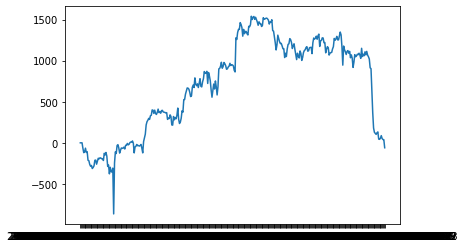

In [71]:
df = pd.read_csv("Data_df/Data 2021-05-21 09_15_00 team.csv")
plt.plot(df['current_datetime'],df['current_pnl'])

In [70]:
df.columns

Index(['underlying_name', 'current_datetime', 'current_pnl', 'strategy_pnl',
       'brokerage_pnl', 'max_pnl', 'trailing_pnl', 'current_ltp',
       'expiry_datetime', 'position_entry_ltp', 'is_closed', 'is_expiry_day',
       'is_broker_working'],
      dtype='object')